# Part 1: NLP Review Rating 

In [84]:
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir('/content/drive/MyDrive/Colab Notebooks')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Preprocess data

In [85]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.offline as py
color = sns.color_palette()
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)
import plotly.tools as tls
import warnings
warnings.filterwarnings('ignore')

from google.colab import files
#df = files.upload()
%matplotlib inline

In [86]:
df= pd.read_csv('GrammarandProductReviews.csv')

In [87]:
df.isnull().sum()

id                          0
brand                       0
categories                  0
dateAdded                   0
dateUpdated                 0
ean                     31979
keys                        0
manufacturer              141
manufacturerNumber        203
name                        0
reviews.date               67
reviews.dateAdded           0
reviews.dateSeen            0
reviews.didPurchase     38886
reviews.doRecommend     10615
reviews.id              38886
reviews.numHelpful      38536
reviews.rating              0
reviews.sourceURLs          0
reviews.text               36
reviews.title             476
reviews.userCity        65634
reviews.userProvince    70595
reviews.username           96
upc                         2
dtype: int64

In [88]:
df = df.dropna(subset=['reviews.text']) #drop the rows having null values

## Visualize the most frequent words in reviews

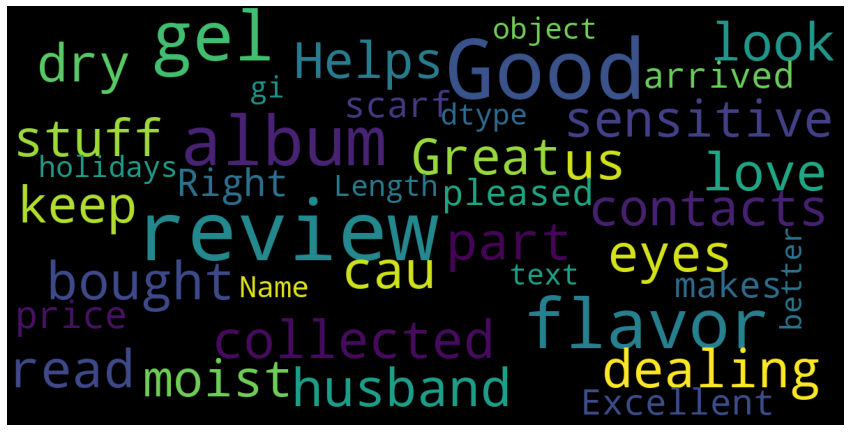

In [89]:
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='black',
        stopwords=stopwords,
        max_words=100,
        max_font_size=40, 
        scale=3,
        random_state=1
).generate(str(data))

    fig = plt.figure(1, figsize=(15, 15))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

show_wordcloud(df['reviews.text'])

## The relationship between the length of the reviews and the rating

In [90]:
df['reviews_length']=df['reviews.text'].apply(len)


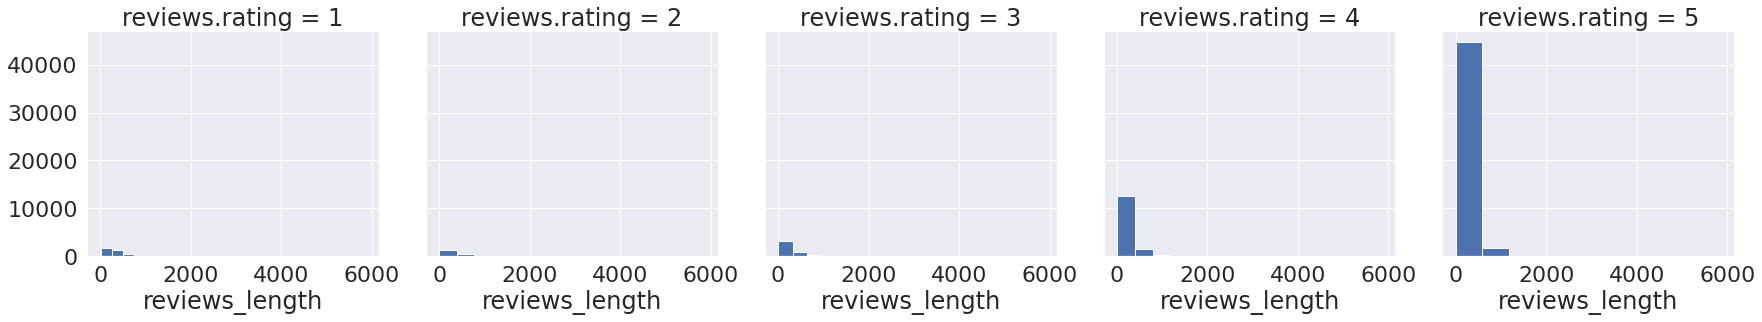

In [91]:
sns.set(font_scale=2.0)

g = sns.FacetGrid(df,col='reviews.rating',size=5)
g.map(plt.hist,'reviews_length')

## DIstribution of Fake news and Genuine news

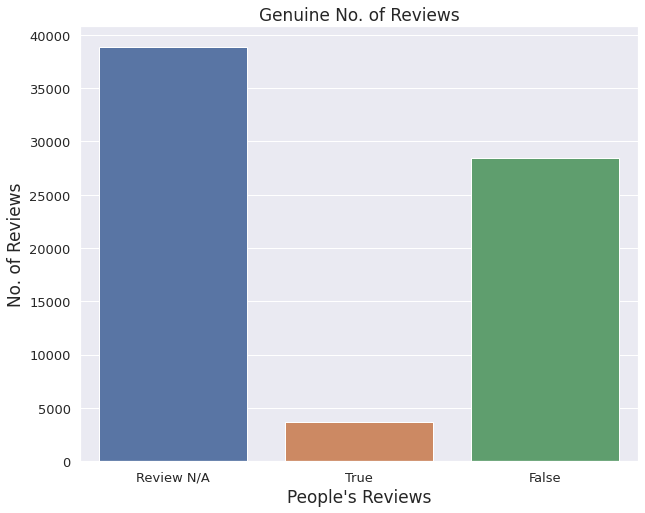

In [92]:
df['reviews.didPurchase'].fillna("Review N/A",inplace=True)
plt.figure(figsize=(10,8))
ax=sns.countplot(df['reviews.didPurchase'])
ax.set_xlabel(xlabel="People's Reviews",fontsize=17)
ax.set_ylabel(ylabel='No. of Reviews',fontsize=17)
ax.axes.set_title('Genuine No. of Reviews',fontsize=17)
ax.tick_params(labelsize=13)

 ## plot the correlation map

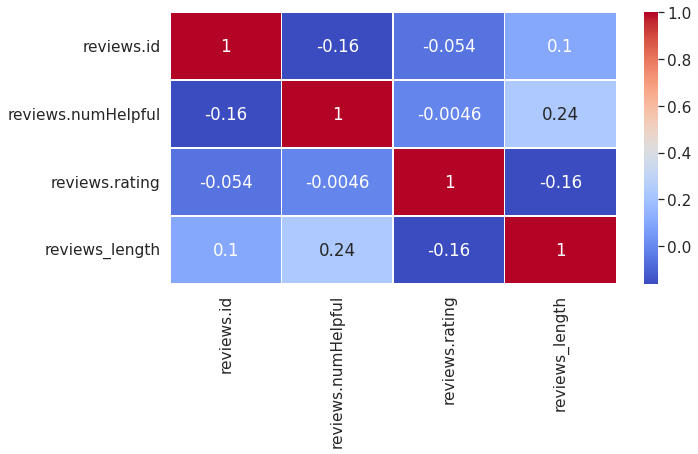

In [93]:
sns.set(font_scale=1.4)
plt.figure(figsize = (10,5))
sns.heatmap(df.corr(),cmap='coolwarm',annot=True,linewidths=.5)

## Pre-process data (convert string data into numerical data) using tf-iddf vectorizer 


In [102]:
from sklearn.model_selection import cross_val_score
from scipy.sparse import hstack
from sklearn.feature_extraction.text import TfidfVectorizer

all_text=df['reviews.text']
train_text=df['reviews.text']
y=df['reviews.rating']

word_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='word',
    token_pattern=r'\w{1,}',
    stop_words='english',
    ngram_range=(1, 1),
    max_features=10000)
word_vectorizer.fit(all_text)
train_word_features = word_vectorizer.transform(train_text)

In [103]:
char_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='char',
    stop_words='english',
    ngram_range=(2, 6),
    max_features=50000)
char_vectorizer.fit(all_text)
train_char_features = char_vectorizer.transform(train_text)

train_features = hstack([train_char_features, train_word_features])

## Bagging (Random Forest Classifier)

In [110]:
X_train.shape

(49705, 60000)

In [107]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_features, y,test_size=0.3,random_state=101)

from sklearn.ensemble import RandomForestClassifier

classifier = RandomForestClassifier()
classifier.fit(X_train[:10000],y_train[:10000])
preds=classifier.predict(X_test)


In [109]:
set(y_train.values)

{1, 2, 3, 4, 5}

In [111]:
from sklearn.metrics import accuracy_score


print(accuracy_score(preds, y_test))

0.6815471999248932


# Part 2: Classifying Toxic Comments

In [108]:
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir('/content/drive/MyDrive/Colab Notebooks')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [112]:
import sys, os, re, csv, codecs, numpy as np, pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers

In [113]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [114]:
#Sneek peak at training and test datasets

train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [115]:
train.isnull().any(),test.isnull().any()

(id               False
 comment_text     False
 toxic            False
 severe_toxic     False
 obscene          False
 threat           False
 insult           False
 identity_hate    False
 dtype: bool, id              False
 comment_text    False
 dtype: bool)

## The dependent variables are in the training set itself so we need to split them up into X and Y sets.

In [116]:
list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
y = train[list_classes].values
list_sentences_train = train["comment_text"]
list_sentences_test = test["comment_text"]

## Use Keras for Tokenization (breaking down the sentence into unique words), Indexing, and Index Representation

In [117]:
max_features = 20000
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(list_sentences_train))
list_tokenized_train = tokenizer.texts_to_sequences(list_sentences_train)
list_tokenized_test = tokenizer.texts_to_sequences(list_sentences_test)

In [118]:
list_tokenized_train[:1]

[[688,
  75,
  1,
  126,
  130,
  177,
  29,
  672,
  4511,
  12052,
  1116,
  86,
  331,
  51,
  2278,
  11448,
  50,
  6864,
  15,
  60,
  2756,
  148,
  7,
  2937,
  34,
  117,
  1221,
  15190,
  2825,
  4,
  45,
  59,
  244,
  1,
  365,
  31,
  1,
  38,
  27,
  143,
  73,
  3462,
  89,
  3085,
  4583,
  2273,
  985]]

In [119]:
maxlen = 200
X_t = pad_sequences(list_tokenized_train, maxlen=maxlen)
X_te = pad_sequences(list_tokenized_test, maxlen=maxlen)

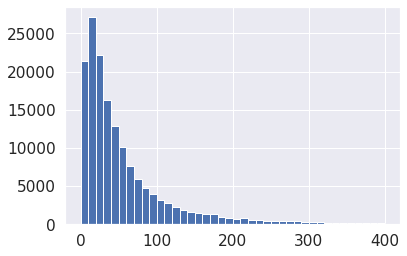

In [120]:
#distribution of the number of words in senences

totalNumWords = [len(one_comment) for one_comment in list_tokenized_train]

plt.hist(totalNumWords,bins = np.arange(0,410,10))#[0,50,100,150,200,250,300,350,400])#,450,500,550,600,650,700,750,800,850,900])
plt.show() #As we can see below, most of the sentence length is about 30+.

## Build a model

In [121]:
inp = Input(shape=(maxlen, )) #maxlen=200 

embed_size = 128
x = Embedding(max_features, embed_size)(inp)

In [122]:
#Next, we feed this Tensor into the LSTM layer.

x = LSTM(60, return_sequences=True,name='lstm_layer')(x)
x = GlobalMaxPool1D()(x) #use a Global Max Pooling layer to reduce the dimensionality of image data


In [123]:
x = Dropout(0.1)(x) #dropout layer

In [124]:
# output passes through a RELU function
x = Dense(50, activation="relu")(x)

In [125]:
x = Dropout(0.1)(x) #feed into dropout layer again

x = Dense(6, activation="sigmoid")(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

#Set our model to optimize a loss function using Adam optimizer
#defined the loss function to be "binary_crossentropy" since we are tackling a binary classification. 

In [126]:
batch_size = 32
epochs = 2

model.fit(X_t,y, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Epoch 1/2
4488/4488 [==============================] - 783s 174ms/step - loss: 0.0715 - accuracy: 0.9466 - val_loss: 0.0488 - val_accuracy: 0.9940
Epoch 2/2
4488/4488 [==============================] - 786s 175ms/step - loss: 0.0447 - accuracy: 0.9857 - val_loss: 0.0463 - val_accuracy: 0.9932


In [127]:
#output a layer (to check the model works)

from keras import backend as K

# with a Sequential model
get_3rd_layer_output = K.function([model.layers[0].input],
                                  [model.layers[2].output])
layer_output = get_3rd_layer_output([X_t[:1]])[0]
layer_output.shape
#print layer_output to see the actual data

(1, 200, 60)

In [128]:
model.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 200)]             0         
                                                                 
 embedding_6 (Embedding)     (None, 200, 128)          2560000   
                                                                 
 lstm_layer (LSTM)           (None, 200, 60)           45360     
                                                                 
 global_max_pooling1d_14 (Gl  (None, 60)               0         
 obalMaxPooling1D)                                               
                                                                 
 dropout_11 (Dropout)        (None, 60)                0         
                                                                 
 dense_8 (Dense)             (None, 50)                3050      
                                                           